In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import Morlet, Cauchy
import time
from scipy import signal

"This notebook requires MAGPRIME for data loading. Uncomment to install."
# !pip install git+https://github.com/aphoffmann/MAGPRIME.git
from magprime import utility

c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\pymssa\mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [2]:
data =  utility.load_swarm_data(160000,165000)[2]
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

"Add interference to the data"
B1 = data + 1000 *np.sin(2 * np.pi * 6.4 * t) + 50 * np.sin(2 * np.pi * .5* t)
B2 = data + 100 *np.sin(2 * np.pi * 6.4 * t) + 10* np.sin(2 * np.pi * .5 * t)
B = np.vstack((B1,B2))

c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\magprime\utility\data_loader.py:28: DtypeWarning: Columns (2,5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path, sep=',',header=None)


#### Create Transform Object and Analysis Filters

In [3]:
fb = DyadicFilterBank(wavelet=Morlet(1,10) , fs=sample_rate, N=10000, real=True, dj = 1/8, s_max=1)
transform = Transform.from_filterbank(fb)

In [4]:
#### WAICUP
start = time.time()
def WAICUP(w1, w2):
    D = w2 - w1  # shape (J, T), complex

    # 1) correlations (eqs 6–7), using conjugate inner products
    C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
    C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

    # 2) gain estimate K̂ per scale (eq 8)
    K_hat = C2 / C1                          # shape (J,)
    # (optionally force to real if you know K is real:)
    K_hat = K_hat

    # 3) residuals (eq 9)
    A = (w1-w2) / (K_hat[:,None]-1)  # shape (J, T), complex

    # 4) ambient‑field estimate X(s,τ) (eq 10)
    X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 
    return X, A

w1 = transform.forward(B[0], mode='full')
w2 = transform.forward(B[1], mode='full')


X1, A1 = WAICUP(w1, w2)

result = transform.inverse(X1, mode='full', Lx=5000)
end = time.time()
print("Time taken for WAICUP: ", end - start)

Time taken for WAICUP:  0.26656103134155273


Raw Error 1:  708.0622756573542
Raw Error 2:  71.0707269011682
Cleaned Error:  0.25500361729332066


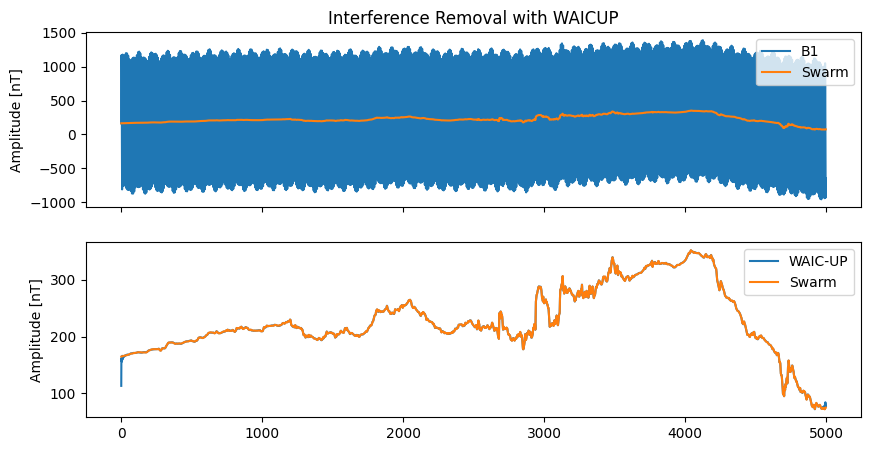

In [5]:
print("Raw Error 1: ", np.sqrt(((B[0,200:-200]-data[200:-200])**2).mean(axis=0)))
print("Raw Error 2: ", np.sqrt(((B[1,200:-200]-data[200:-200])**2).mean(axis=0)))
print("Cleaned Error: ", np.sqrt(((data[1000:-1000]-result[:5000][1000:-1000])**2).mean(axis=0)))

%matplotlib inline
fig, ax = plt.subplots(2,1, sharex=True, figsize=(10, 5))


ax[0].plot(B[0], label='B1')
ax[0].plot(data, label='Swarm')
ax[1].plot(result, label='WAIC-UP')
ax[1].plot(data, label='Swarm')
ax[0].set_title('Interference Removal with WAICUP')
ax[0].set_ylabel('Amplitude [nT]')

ax[1].set_ylabel('Amplitude [nT]')
ax[0].legend()
ax[1].legend()
plt.show()